## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline


# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

2021-11-23 10:53:21.183053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 10:53:21.183104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_focal_loss(y_true, y_pred):
        """ Focal loss for multi-classification
        FL(p_t) = alpha(1-p_t)^(gamma)ln(p_t)
        """    
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)

        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)

        return (ce_weights*ce_loss)+(fcl_weights*tf.reduce_mean(reduced_fl))

    return CE_focal_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [9]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.gradient_descent_v2.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weights=ce_w, fcl_weights=1.-ce_w),
                 metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_5 (B

2021-11-23 11:20:03.498207: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 4s 59ms/step - loss: 6.0107 - accuracy: 0.3318 - val_loss: 6.6398 - val_accuracy: 0.2519
Epoch 2/25
49/49 [==============================] - 3s 53ms/step - loss: 4.3991 - accuracy: 0.4409 - val_loss: 5.7420 - val_accuracy: 0.2967
Epoch 3/25
49/49 [==============================] - 3s 51ms/step - loss: 4.0093 - accuracy: 0.4807 - val_loss: 4.8973 - val_accuracy: 0.3814
Epoch 4/25
49/49 [==============================] - 2s 49ms/step - loss: 3.7377 - accuracy: 0.5081 - val_loss: 4.4126 - val_accuracy: 0.4410
Epoch 5/25
49/49 [==============================] - 2s 47ms/step - loss: 3.5255 - accuracy: 0.5282 - val_loss: 4.2416 - val_accuracy: 0.4522
Epoch 6/25
49/49 [==============================] - 2s 49ms/step - loss: 3.3412 - accuracy: 0.5472 - val_loss: 4.0147 - val_accuracy: 0.4745
Epoch 7/25
49/49 [==============================] - 2s 48ms/step - loss: 3.1713 - accuracy: 0.5645 - val_loss: 4.0552 - val_accuracy: 0.4715
Epoch 8/25
49

2021-11-23 11:21:05.153359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 3s 54ms/step - loss: 4.8930 - accuracy: 0.3241 - val_loss: 5.1385 - val_accuracy: 0.2243
Epoch 2/25
49/49 [==============================] - 2s 44ms/step - loss: 3.6069 - accuracy: 0.4332 - val_loss: 4.5216 - val_accuracy: 0.3123
Epoch 3/25
49/49 [==============================] - 2s 45ms/step - loss: 3.2825 - accuracy: 0.4750 - val_loss: 3.9735 - val_accuracy: 0.3915
Epoch 4/25
49/49 [==============================] - 2s 44ms/step - loss: 3.0724 - accuracy: 0.5018 - val_loss: 3.5934 - val_accuracy: 0.4397
Epoch 5/25
49/49 [==============================] - 2s 44ms/step - loss: 2.9066 - accuracy: 0.5223 - val_loss: 3.4250 - val_accuracy: 0.4510
Epoch 6/25
49/49 [==============================] - 2s 45ms/step - loss: 2.7706 - accuracy: 0.5392 - val_loss: 3.3045 - val_accuracy: 0.4638
Epoch 7/25
49/49 [==============================] - 2s 45ms/step - loss: 2.6439 - accuracy: 0.5541 - val_loss: 3.2290 - val_accuracy: 0.4676
Epoch 8/25
49

2021-11-23 11:22:01.727875: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 4s 55ms/step - loss: 4.1813 - accuracy: 0.3098 - val_loss: 4.6512 - val_accuracy: 0.1969
Epoch 2/25
49/49 [==============================] - 2s 45ms/step - loss: 3.1021 - accuracy: 0.4260 - val_loss: 3.7570 - val_accuracy: 0.3263
Epoch 3/25
49/49 [==============================] - 2s 45ms/step - loss: 2.8378 - accuracy: 0.4663 - val_loss: 3.3227 - val_accuracy: 0.3966
Epoch 4/25
49/49 [==============================] - 2s 44ms/step - loss: 2.6694 - accuracy: 0.4908 - val_loss: 3.1125 - val_accuracy: 0.4213
Epoch 5/25
49/49 [==============================] - 2s 44ms/step - loss: 2.5356 - accuracy: 0.5134 - val_loss: 2.9447 - val_accuracy: 0.4414
Epoch 6/25
49/49 [==============================] - 2s 44ms/step - loss: 2.4230 - accuracy: 0.5317 - val_loss: 2.7959 - val_accuracy: 0.4706
Epoch 7/25
49/49 [==============================] - 2s 44ms/step - loss: 2.3193 - accuracy: 0.5493 - val_loss: 2.7615 - val_accuracy: 0.4738
Epoch 8/25
49

2021-11-23 11:23:00.183029: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
49/49 [==============================] - 3s 53ms/step - loss: 3.4026 - accuracy: 0.3049 - val_loss: 3.4627 - val_accuracy: 0.1811
Epoch 2/25
49/49 [==============================] - 2s 48ms/step - loss: 2.5747 - accuracy: 0.4165 - val_loss: 3.0636 - val_accuracy: 0.3093
Epoch 3/25
49/49 [==============================] - 2s 50ms/step - loss: 2.3559 - accuracy: 0.4601 - val_loss: 2.7977 - val_accuracy: 0.3751
Epoch 4/25
49/49 [==============================] - 2s 48ms/step - loss: 2.2271 - accuracy: 0.4853 - val_loss: 2.5535 - val_accuracy: 0.4275
Epoch 5/25
49/49 [==============================] - 3s 56ms/step - loss: 2.1237 - accuracy: 0.5050 - val_loss: 2.4411 - val_accuracy: 0.4415
Epoch 6/25
49/49 [==============================] - 3s 56ms/step - loss: 2.0415 - accuracy: 0.5213 - val_loss: 2.3591 - val_accuracy: 0.4502
Epoch 7/25
49/49 [==============================] - 2s 50ms/step - loss: 1.9632 - accuracy: 0.5382 - val_loss: 2.3018 - val_accuracy: 0.4590
Epoch 8/25
49

49/49 [==============================] - 2s 45ms/step - loss: 0.9944 - accuracy: 0.6622 - val_loss: 1.4771 - val_accuracy: 0.4937
Epoch 24/25
49/49 [==============================] - 2s 44ms/step - loss: 0.9741 - accuracy: 0.6715 - val_loss: 1.4863 - val_accuracy: 0.4845
Epoch 25/25
49/49 [==============================] - 2s 45ms/step - loss: 0.9513 - accuracy: 0.6804 - val_loss: 1.4677 - val_accuracy: 0.4971


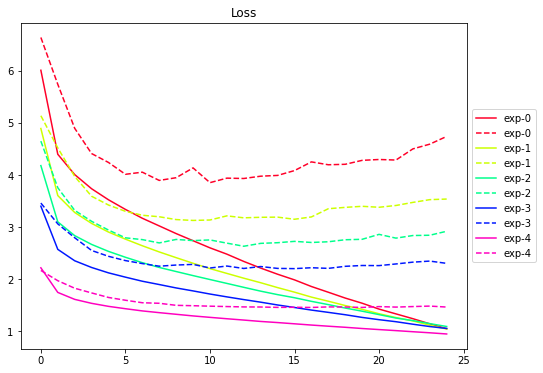

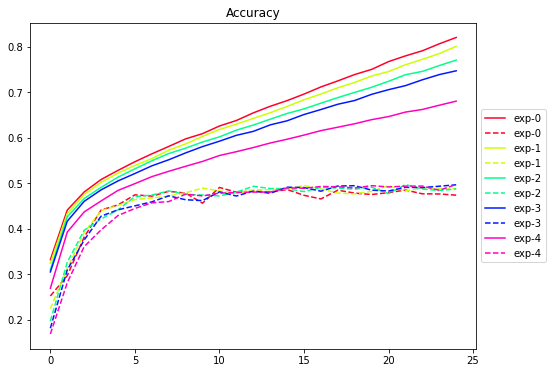

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()